# Post-operative prediction using Bayesian Networks
FAIKR module 3 project.

Authors:
 - Michele Calvanese
 - Samuele Marino

## Introduction

Postoperative patient care has several components: - surveillance, − prevention of complications associated with surgical disease or other preexisting comorbidities, − specific postoperative treatment of the surgical disease and its complications. While these distinctions are purely didactic, the postoperative care merges into an active surveillance with a higher level of standardization than it would seem at first glance.

The goal of this project is to determine where patients in a postoperative recovery area should be sent to next. Because hypothermia is a significant concern after surgery, the attributes correspond roughly to body temperature measurements.

Number of Instances: 90

Number of Attributes: 9 including the decision (class attribute)

Attribute Information:

1. ``L-CORE`` (patient's internal temperature in C):
            
            high (> 37), mid (>= 36 and <= 37), low (< 36)
2. ``L-SURF`` (patient's surface temperature in C):
              
              high (> 36.5), mid (>= 36.5 and <= 35), low (< 35)
3. ``L-O2`` (oxygen saturation in %):
              
              excellent (>= 98), good (>= 90 and < 98),
              fair (>= 80 and < 90), poor (< 80)
4. ``L-BP`` (last measurement of blood pressure):
              
              high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70)
5. ``SURF-STBL`` (stability of patient's surface temperature):
              
              stable, mod-stable, unstable
6. ``CORE-STBL`` (stability of patient's core temperature)
              
              stable, mod-stable, unstable
7. ``BP-STBL`` (stability of patient's blood pressure)
              
              stable, mod-stable, unstable
8. ``COMFORT`` (patient's perceived comfort at discharge, measured as
              
              an integer between 0 and 20)
9. ``ADM-DECS`` (discharge decision):
              
              I (patient sent to Intensive Care Unit),
              S (patient prepared to go home),
              A (patient sent to general hospital floor)

Class Distribution:
     
     I (2)
     S (24)
     A (64)


Dataset [link](https://archive.ics.uci.edu/ml/datasets/Post-Operative+Patient).

In [1]:
import pandas as pd
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination, ApproxInference
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, K2Score, BayesianEstimator
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from time import time

## Data cleaning and preparation

All attributes were used for making the Bayesian Network model. Before creating the model, all the attributes need to be discretized, as the ``pgmpy`` library only works with discrete variables.

In [2]:
path = "./Dataset/post-operative.data"
attributes = ['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL', 'BP-STBL', 'COMFORT', 'ADM-DECS']
data = pd.read_csv(path, sep=',', header=None, names=attributes)
data.head()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,ADM-DECS
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


Verify the value of all attributes:

In [3]:
for attribute in data.columns:
    print(attribute, ':', data[attribute].unique())

L-CORE : ['mid' 'high' 'low']
L-SURF : ['low' 'high' 'mid']
L-O2 : ['excellent' 'good']
L-BP : ['mid' 'high' 'low']
SURF-STBL : ['stable' 'unstable']
CORE-STBL : ['stable' 'unstable' 'mod-stable']
BP-STBL : ['stable' 'mod-stable' 'unstable']
COMFORT : ['15' '10' '05' '07' '?']
ADM-DECS : ['A' 'S' 'A ' 'I']


In attribute ``ADM-DECS`` there are some occurrences of the value ``'A'`` that are written incorrectly with a trailing space. We therefore replace the incorrect occurrences of ``'A '`` with ``'A'``.

In [4]:
data = data.replace({'A ': 'A'})
data['ADM-DECS'].unique()

array(['A', 'S', 'I'], dtype=object)

Also in ``COMFORT`` there are inconsistent values. For this reason, we remove all the rows where ``'?'`` is present. In addition, we discretize the values of ``COMFORT`` into bins.

In [5]:
data = data.drop(data[data.COMFORT == '?'].index)

data['COMFORT'] = pd.cut(x=data['COMFORT'].astype(int),
                         bins=[0, 5, 10, 15, 20],
                         labels=["low", "mid", "high", "excellent"])
data['COMFORT'].unique()

['high', 'mid', 'low']
Categories (4, object): ['low' < 'mid' < 'high' < 'excellent']

Before modifying the variables, the dataset is checked for the presence of ``N/A`` values.

In [6]:
data.isnull().sum()

L-CORE       0
L-SURF       0
L-O2         0
L-BP         0
SURF-STBL    0
CORE-STBL    0
BP-STBL      0
COMFORT      0
ADM-DECS     0
dtype: int64

So there are no ``N/A`` values.

After the cleanup, we show the number of samples and the new unique attributes:

In [7]:
print(f"Number of samples: {data.shape[0]}")
print(f"Number of attributes: {data.shape[1]}")

print("\nAttribute values:")
for attribute in data.columns:
    print(attribute, ':', data[attribute].unique())

Number of samples: 87
Number of attributes: 9

Attribute values:
L-CORE : ['mid' 'high' 'low']
L-SURF : ['low' 'high' 'mid']
L-O2 : ['excellent' 'good']
L-BP : ['mid' 'high' 'low']
SURF-STBL : ['stable' 'unstable']
CORE-STBL : ['stable' 'unstable' 'mod-stable']
BP-STBL : ['stable' 'mod-stable' 'unstable']
COMFORT : ['high', 'mid', 'low']
Categories (4, object): ['low' < 'mid' < 'high' < 'excellent']
ADM-DECS : ['A' 'S' 'I']


In [8]:
data.head()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,ADM-DECS
0,mid,low,excellent,mid,stable,stable,stable,high,A
1,mid,high,excellent,high,stable,stable,stable,mid,S
2,high,low,excellent,high,stable,stable,mod-stable,mid,A
3,mid,low,good,high,stable,unstable,mod-stable,high,A
4,mid,mid,excellent,high,stable,stable,stable,mid,A


##  Bayesian Network

### Learning the structure of the network

One option for defining the structure of the network would be to manually add the nodes and connections between them. Knowing the connections between nodes requires having a sufficient knowledge about the field of application in order to be able to define conditional independence assertions. 

Luckily, the ``pgmpy`` library offers many ways to learn a structure for discrete, fully observed networks. Given a set of data samples, the algorithm estimates a directed acyclic graph that captures dependencies between the variables. We will use Score-based structure estimation, that learns the model as an optimization task, and lets the programmer choose a search strategy and a scoring function which will be used.

Some of the available search strategies are:

- Exhaustive search
- Hill Climb search

The search space is super-exponential in the number of variables, which is the reason why Exhaustive search wasn't chosen for this particular project. However, for a very small number of nodes, it is guaranteed to find the best-scoring graph. When networks are bigger it is better to use Hill Climb search, which implements a greedy local search starting usually from a disconnected graph. In every iteration it makes one change on edges of the graph that maximally increases the score.

However, this approach often leads to inconsistent results: the node ``ADM-DECS`` may have exiting edges (which we do not want, because this is the attribute we want to predict), or multiple disconnected graphs may be found. We therefore remove all the edges that have ``ADM-DECS`` as parent. In addition, according to scientific medical sources [[link1](https://www.intechopen.com/chapters/76686), [link2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2582826/), [link3](https://bmcnurs.biomedcentral.com/articles/10.1186/1472-6955-11-24)], we force the learning algorithm to include the following edges in the network: ``('BP-STBL', 'ADM-DECS')``, ``('L-O2', 'ADM-DECS')``, ``('SURF-STBL', 'ADM-DECS')``.


In [9]:
black_list = [('ADM-DECS', attribute) for attribute in data.columns[:-1]]
fixed_attributes = ['BP-STBL', 'L-O2', 'SURF-STBL']
fixed_edges = [(attribute, 'ADM-DECS') for attribute in fixed_attributes]

#learning the stucutre of the network
est = HillClimbSearch(data, use_cache=False)
best_model = est.estimate(scoring_method=K2Score(data),
                          black_list=black_list,
                          fixed_edges=fixed_edges)

  0%|          | 6/1000000 [00:00<23:44:16, 11.70it/s]


In [10]:
#the estimated model returns a DAG at a (local) score maximum
edges = list(best_model.edges())
model = BayesianNetwork(edges)

#nodes of the model
model.nodes

NodeView(('L-CORE', 'BP-STBL', 'L-SURF', 'SURF-STBL', 'L-O2', 'ADM-DECS', 'L-BP', 'CORE-STBL', 'COMFORT'))

In [11]:
#edges of the model
model.edges

OutEdgeView([('L-CORE', 'BP-STBL'), ('BP-STBL', 'ADM-DECS'), ('L-SURF', 'SURF-STBL'), ('SURF-STBL', 'ADM-DECS'), ('L-O2', 'ADM-DECS'), ('L-BP', 'BP-STBL'), ('CORE-STBL', 'SURF-STBL'), ('CORE-STBL', 'L-O2'), ('COMFORT', 'L-O2')])

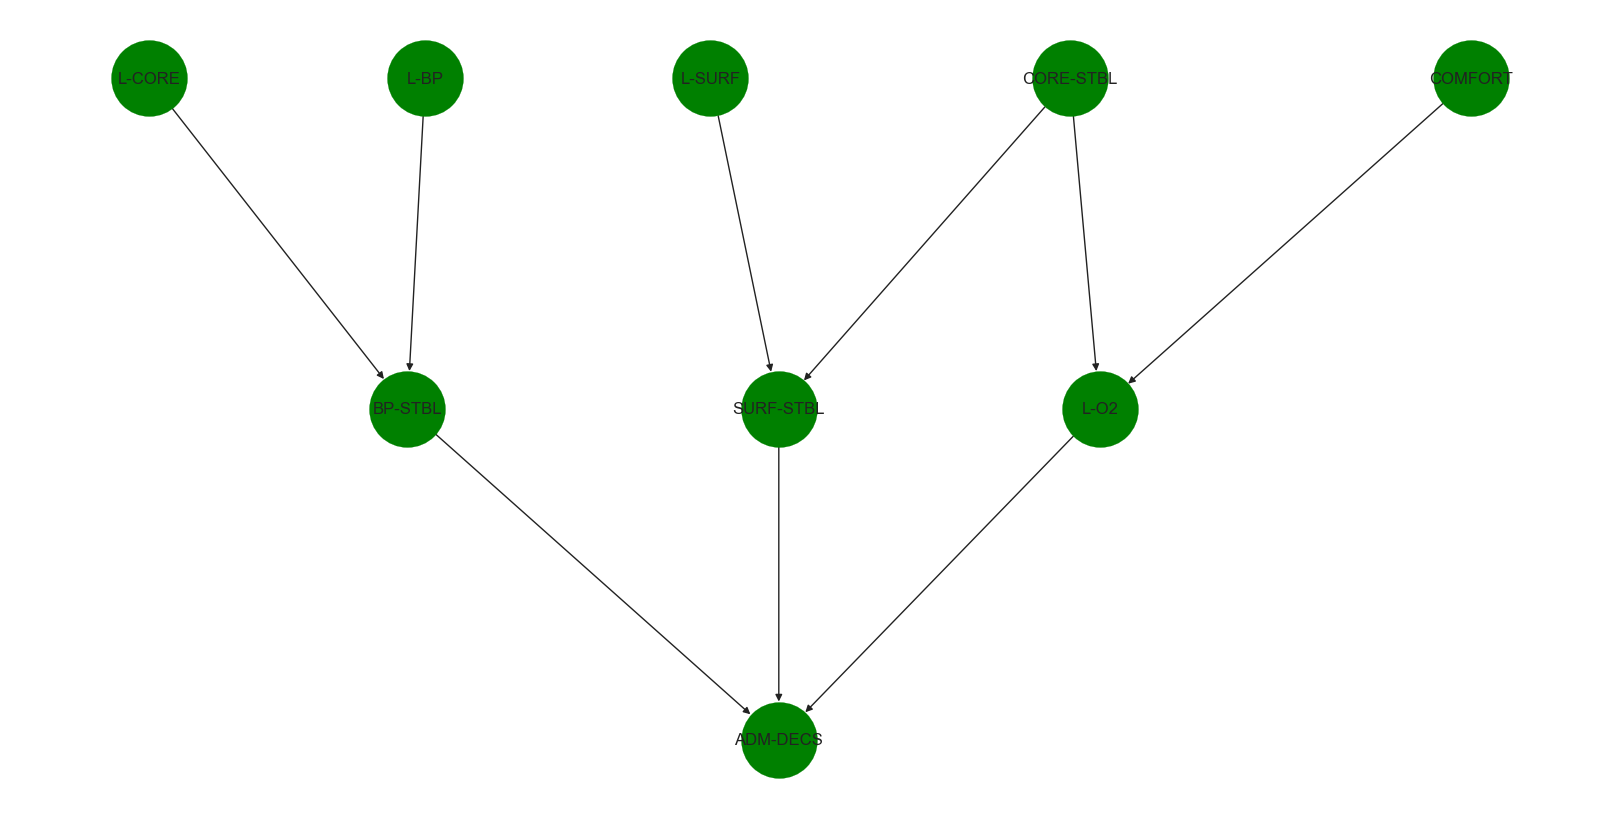

In [12]:
pos = graphviz_layout(model, prog="dot")
plt.figure(figsize=(16, 8))
nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
plt.savefig('model.png')
plt.show()

### Learning the parameters and analyzing of the network

As mentioned before, ``pgmpy`` currently supports parameter learning only for networks with discrete nodes. There are 2 available methods for determining the values of the conditional probability distributions:

- Maximum Likelihood estimation.

       This method uses relative frequencies for estimating conditional probabilities. 
       However, in case of small datasets, it is prone to overfitting.
- Bayesian estimation.

       On the other hand, the Bayesian estimator assumes prior CPDs on variables and 
       then updates them using state counts from observed data.

Because our dataset has only 87 samples after cleaning, we use __Bayesian estimation__.

In [13]:
model.fit(data=data, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, 2*'\n', 80*"=", '\n')

CPT of L-CORE:
+--------------+----------+
| L-CORE(high) | 0.148551 |
+--------------+----------+
| L-CORE(low)  | 0.213768 |
+--------------+----------+
| L-CORE(mid)  | 0.637681 |
+--------------+----------+ 


CPT of BP-STBL:
+---------------------+-----+---------------------+
| L-BP                | ... | L-BP(mid)           |
+---------------------+-----+---------------------+
| L-CORE              | ... | L-CORE(mid)         |
+---------------------+-----+---------------------+
| BP-STBL(mod-stable) | ... | 0.19132149901380668 |
+---------------------+-----+---------------------+
| BP-STBL(stable)     | ... | 0.5374753451676528  |
+---------------------+-----+---------------------+
| BP-STBL(unstable)   | ... | 0.27120315581854043 |
+---------------------+-----+---------------------+ 


CPT of L-SURF:
+--------------+----------+
| L-SURF(high) | 0.192029 |
+--------------+----------+
| L-SURF(low)  | 0.278986 |
+--------------+----------+
| L-SURF(mid)  | 0.528986 |
+-----------

Checking if there are no errors.

In [14]:
model.check_model()

True

Cardinality of all model nodes.

In [15]:
model.get_cardinality()

defaultdict(int,
            {'L-CORE': 3,
             'BP-STBL': 3,
             'L-SURF': 3,
             'SURF-STBL': 2,
             'L-O2': 2,
             'ADM-DECS': 3,
             'L-BP': 3,
             'CORE-STBL': 3,
             'COMFORT': 3})

Local independecies of a signle node, namely ``SURF-STBL`` (stability of the patient's surface temperature).

In this simplification of a real scenario, the structure stability of the patient's blood pressure (``BP-STBL``), the last measure of blood pressure (``L-BP``), oxygen saturation (``L-O2``), perceived comfort (``COMFORT``) and the patient's internal temperature (``L-CORE``) do not directly influence the stability of the patient's surface temperature (``SURF-STBL``), given their influence on the stability core temperature (``CORE-STBL``) and the patient's surface temperature (``L-SURF``).


In [16]:
model.local_independencies("SURF-STBL")

(SURF-STBL ⟂ L-CORE, L-O2, BP-STBL, COMFORT, L-BP | L-SURF, CORE-STBL)

Checking d-separation between variables with and without evidence.

Two sets of nodes $\mathbf{X}$, $\mathbf{Y}$ are d-separated given $\mathbf{Z}$ if there is no active trail between any $X \in \mathbf{X}$ and $Y \in \mathbf{Y}$ given $\mathbf{Z}$.


In [17]:
# direct path
print(model.is_dconnected("COMFORT", "L-O2"))
# common cause not in evidence
print(model.is_dconnected("L-O2", "SURF-STBL"))
# common cause in evidence
print(model.is_dconnected("L-O2", "SURF-STBL", observed = ["CORE-STBL"]))
# common effect not in evidence (non-activated V-structure)
print(model.is_dconnected("COMFORT", "CORE-STBL"))
# common effect in evidence (activated V-structure)
print(model.is_dconnected("COMFORT", "CORE-STBL", observed = ["L-O2"]))

True
True
False
False
True


Checking the Markov blanket for ``ADM-DECS`` and ``L-O2``.

In [18]:
print("Markov blankets for variable:")
print("ADM-DECS: ", model.get_markov_blanket("ADM-DECS"))
print("L-O2: ", model.get_markov_blanket("L-O2"))

Markov blankets for variable:
ADM-DECS:  ['L-O2', 'BP-STBL', 'SURF-STBL']
L-O2:  ['BP-STBL', 'CORE-STBL', 'COMFORT', 'ADM-DECS', 'SURF-STBL']


## Inference

### Exact inference

Pgmpy library offers two ways of doing exact inference, *Variable Elimination method*, presented bellow, and *Belief Propagation method*. The basic concept of Variable Elimination is in a way similar to doing marginalization over Joint Distribution, except that it doesn't compute the complete Joint Distribution but marginalizes just over factors that involve the variable that is being eliminated. 

In [19]:
infer_exact = VariableElimination(model)

In [20]:
print("Probability of discharge decision:\n")
print(infer_exact.query(["ADM-DECS"]))

Probability of discharge decision:



Eliminating: CORE-STBL: 100%|██████████| 8/8 [00:00<00:00, 891.22it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.6878 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0311 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2811 |
+-------------+-----------------+


#### Causal inference (prediction):

What is the discharge decision given patient's internal temperature high and oxygen saturation excellent?

In [21]:
print(infer_exact.query(["ADM-DECS"], {'L-CORE': 'high', 'L-O2': 'excellent'}))

Eliminating: CORE-STBL: 100%|██████████| 6/6 [00:00<00:00, 1002.82it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.7137 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0250 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2613 |
+-------------+-----------------+


#### Evidential inference (explaination):

Explaining the prob of stability of patient's blood pressure given that the patient was sent to Intensive Care Unit.

In [22]:
print(infer_exact.query(["BP-STBL"], evidence={"ADM-DECS": 'I'}))

Eliminating: SURF-STBL: 100%|██████████| 7/7 [00:00<00:00, 1170.29it/s]

+---------------------+----------------+
| BP-STBL             |   phi(BP-STBL) |
+=====================+================+
| BP-STBL(mod-stable) |         0.2140 |
+---------------------+----------------+
| BP-STBL(stable)     |         0.1953 |
+---------------------+----------------+
| BP-STBL(unstable)   |         0.5907 |
+---------------------+----------------+


#### Intercausal inference (explaining away):

Why was the patient sent to the general hospital floor given the fact that he had surface temperature unstable and blood pressure on average stable?

In [23]:
print(infer_exact.query(["L-O2"], evidence={"ADM-DECS": 'A', "SURF-STBL": 'unstable', "BP-STBL": 'mod-stable'}))

Eliminating: CORE-STBL: 100%|██████████| 3/3 [00:00<00:00, 1503.33it/s]

+-----------------+-------------+
| L-O2            |   phi(L-O2) |
+=================+=============+
| L-O2(excellent) |      0.4297 |
+-----------------+-------------+
| L-O2(good)      |      0.5703 |
+-----------------+-------------+


#### Inferences using hard evidence

In [24]:
print(infer_exact.query(["ADM-DECS"], evidence={"L-O2": 'excellent', "SURF-STBL": 'stable', "BP-STBL": 'stable'}))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.7360 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0112 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2528 |
+-------------+-----------------+


#### The joint probability:

What is the probability of patient's oxygen saturation and surface temperature given that his core temperature is unstable?


In [25]:
print(infer_exact.query(['L-O2', 'SURF-STBL'], evidence = {'CORE-STBL': 'unstable'}))

Eliminating: COMFORT: 100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]

+---------------------+-----------------+-----------------------+
| SURF-STBL           | L-O2            |   phi(SURF-STBL,L-O2) |
+=====================+=================+=======================+
| SURF-STBL(stable)   | L-O2(excellent) |                0.2000 |
+---------------------+-----------------+-----------------------+
| SURF-STBL(stable)   | L-O2(good)      |                0.0769 |
+---------------------+-----------------+-----------------------+
| SURF-STBL(unstable) | L-O2(excellent) |                0.5224 |
+---------------------+-----------------+-----------------------+
| SURF-STBL(unstable) | L-O2(good)      |                0.2008 |
+---------------------+-----------------+-----------------------+


### Approximate Inference

In ``pgmpy``, approximate Inference is implemented with a number of different sampling methods. In particular, in this section the main focus is on the ones seen during the course.
We will apply approximate inference to show convergence to the exact probability distribution as we increase the number of samples.

In [26]:
infer_approx = ApproxInference(model)
sampling_bayesian = BayesianModelSampling(model)

samples_low = 10
samples_high = 10000

#### Sampling comparison

Here we compare the efficiency of likelihood-weighted sampling and rejection sampling.

In [27]:
#query = ["ADM-DECS"]
evidence = {"L-SURF": "low", "L-BP": "high", "COMFORT": "high"}

#just because pgmpy wants it like this
evidence_nt = [(key, value) for key, value in evidence.items()]

start = time()
sampling_bayesian.rejection_sample(size=samples_high)
time_rejection_no_evidence = time() - start

start = time()
sampling_bayesian.likelihood_weighted_sample(size=samples_high)
time_likelihood_no_evidence = time() - start

start = time()
sampling_bayesian.rejection_sample(evidence_nt, size=samples_high)
time_rejection = time() - start

start = time()
sampling_bayesian.likelihood_weighted_sample(evidence_nt, size=samples_high)
time_likelihood = time() - start

print(f"Execution time for rejection sampling without evidence: {time_rejection_no_evidence:.3f} s")
print(f"Execution time for likelihood sampling without evidence: {time_likelihood_no_evidence:.3f} s")
print(f"Execution time for rejection sampling with evidence: {time_rejection:.3f} s")
print(f"Execution time for likelihood sampling with evidence: {time_likelihood:.3f} s")

Generating for node: CORE-STBL:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
Generating for node: CORE-STBL:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
Generating for node: 

Execution time for rejection sampling without evidence: 0.061 s
Execution time for likelihood sampling without evidence: 0.057 s
Execution time for rejection sampling with evidence: 2.935 s
Execution time for likelihood sampling with evidence: 0.064 s


Likelihood weighted sampling is not affected by the evidence, whereas rejection sampling is. Therefore, likelihood weighted sampling should be preferred in general. With no attribute in the evidence, there is no difference between the two approaches.

#### Showing the convergence with an increasing number of samples


Approximate probability with a low number of samples.

In [28]:
print(infer_approx.query(variables=["ADM-DECS"], n_samples=samples_low))

Generating for node: CORE-STBL:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
Generating for node: ADM-DECS: 100%|██████████| 9/9 [00:00<00:00, 567.78it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.4000 |
+-------------+-----------------+
| ADM-DECS(I) |          0.1000 |
+-------------+-----------------+
| ADM-DECS(S) |          0.5000 |
+-------------+-----------------+


Approximate probability with a high number of samples.

In [29]:
print(infer_approx.query(variables=["ADM-DECS"], n_samples=samples_high))

Generating for node: CORE-STBL:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
Generating for node: ADM-DECS: 100%|██████████| 9/9 [00:00<00:00, 196.26it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.6872 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0298 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2830 |
+-------------+-----------------+


As can be seen, using a high number of samples results in a more accurate estimation of the true probability distribution.

As a reference, here is the true probability distribution.

In [30]:
print(infer_exact.query(["ADM-DECS"]))

Eliminating: CORE-STBL: 100%|██████████| 8/8 [00:00<00:00, 1002.73it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.6878 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0311 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2811 |
+-------------+-----------------+


The convergence of discharge decision given patient's perceived comfort ``'high'`` and internal temperature ``'low'``.


Approximate probability with a low number of samples.

In [31]:
samples = sampling_bayesian.likelihood_weighted_sample(evidence=[('COMFORT', 'high'), ('L-CORE', 'low')], size=samples_low)
print(infer_approx.get_distribution(samples, variables=["ADM-DECS"]))

Generating for node: CORE-STBL:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
Generating for node: ADM-DECS: 100%|██████████| 9/9 [00:00<00:00, 564.01it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.5000 |
+-------------+-----------------+
| ADM-DECS(S) |          0.5000 |
+-------------+-----------------+


In [32]:
samples = sampling_bayesian.likelihood_weighted_sample(evidence=[('COMFORT', 'high'), ('L-CORE', 'low')], size=samples_high)
print(infer_approx.get_distribution(samples, variables=["ADM-DECS"]))

Generating for node: CORE-STBL:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\calva\miniconda3\envs\faikr3\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
Generating for node: ADM-DECS: 100%|██████████| 9/9 [00:00<00:00, 188.00it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.6755 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0331 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2914 |
+-------------+-----------------+


## Conclusion analysis

We now want to make a statistical analysis on what are the parameters that lead the doctors to send a patient home, let him remain in hospital, or let him go the ICU. To do this, we make some queries on the bayesian network we created on our dataset.

#### A healthy patient

We use this as a baseline to compare the other two patients with.

In [33]:
evidence = {'BP-STBL': 'stable',
            'L-SURF': 'mid',
            'CORE-STBL': 'stable',
            'L-O2': 'excellent',
            'L-BP': 'mid'}
print(infer_exact.query(["ADM-DECS"], evidence=evidence))

Eliminating: SURF-STBL: 100%|██████████| 1/1 [00:00<?, ?it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.6996 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0127 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2876 |
+-------------+-----------------+


#### An unhealthy patient

The probability of being sent to the ICU goes from 1% to 12%, and the probability of being sent home does not change much (it goes from 29% to 27%).

In [34]:
evidence = {'BP-STBL': 'unstable',
            'L-SURF': 'high',
            'CORE-STBL': 'unstable',
            'L-O2': 'good',
            'L-BP': 'low'}
print(infer_exact.query(["ADM-DECS"], evidence=evidence))

Eliminating: SURF-STBL: 100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]

+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.6123 |
+-------------+-----------------+
| ADM-DECS(I) |          0.1160 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2718 |
+-------------+-----------------+


#### An in-between patient

The probability of being sent to the ICU increases from 1% to 3%, but the probability to go home drops from 29% to 24%.

In [35]:
evidence = {'BP-STBL': 'mod-stable',
            'L-SURF': 'high',
            'CORE-STBL': 'stable',
            'L-BP': 'low'}
print(infer_exact.query(["ADM-DECS"], evidence=evidence))

Eliminating: SURF-STBL: 100%|██████████| 3/3 [00:00<00:00, 1003.50it/s]


+-------------+-----------------+
| ADM-DECS    |   phi(ADM-DECS) |
+=============+=================+
| ADM-DECS(A) |          0.7487 |
+-------------+-----------------+
| ADM-DECS(I) |          0.0283 |
+-------------+-----------------+
| ADM-DECS(S) |          0.2229 |
+-------------+-----------------+


As can be seen, the probability of being sent to the ICU depends on how healthy the patient is.